В настоящем задании на основе учебного ноутбука нам необходимо было провести финальную подготовку данных, изменив количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

А также нужно реализовать сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .



## Подготовка


### Импорт библиотек

In [1]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Импортируем библиотеку numpy
import numpy as np 

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами 
import os 

# Для генерации случайных чисел 
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image 

# очистка ОЗУ
import gc 

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а

from tensorflow.keras.metrics import CategoricalAccuracy

from tensorflow.keras.metrics import categorical_crossentropy

from keras.utils.vis_utils import plot_model

from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления

### Загрузка датасета

грузим и распаковываем архив картинок

In [2]:
# Загрузка датасета из облака
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_1024x768.zip', None, quiet=True)
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_512x384.zip', None, quiet=True)
gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_256x192.zip', None, quiet=True)

!unzip -q 'construction_256x192.zip'  # распоковываем архив

## Решение

In [3]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки 
IMG_HEIGHT = 256              # Высота картинки 
CLASS_COUNT = 7              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки
num_classes=7

In [4]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [5]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [6]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.74 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.04 с
Количество изображений: 100


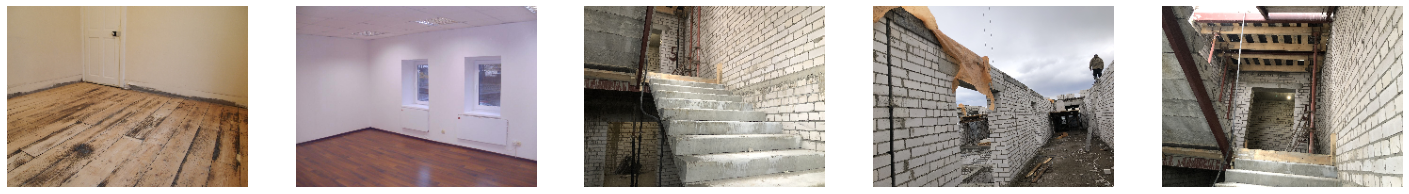

In [7]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [8]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.94 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.05 с
Количество изображений: 100


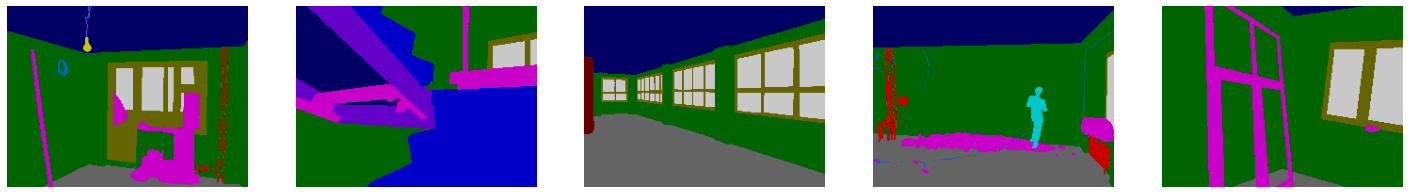

In [9]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [10]:
# Цвета пикселов сегментированных изображений при делении на 16 классов

#FLOOR = (100, 100, 100)         # Пол (серый)
#CEILING = (0, 0, 100)           # Потолок (синий)
#WALL = (0, 100, 0)              # Стена (зеленый)
#COLUMN = (100, 0, 0)            # Колонна (красный)
#APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
#DOOR = (100, 0, 100)            # Дверь (бордовый)
#WINDOW = (100, 100, 0)          # Окно (золотой)
#EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
#RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
#BATTERY = (200, 0, 0)           # Батареи (светло-красный)
#PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
#LADDER = (0, 0, 200)            # Лестница (светло-синий)
#INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
#LAMP = (200, 200, 0)            # Лампа (желтый)
#WIRE = (0, 100, 200)            # Провод (голубой)
#BEAM = (100, 0, 200)            # Балка (фиолетовый)

In [11]:
# зададим цвета пикселей сегментированных изображений при делении на 7 классов

FLOOR = (100, 100, 100)                       # Пол (серый)
CEILING = (0, 0, 100)                         # Потолок (синий)
WALL = (0, 100, 0)                            # Стена (зеленый)
APERTURE = (0, 100, 100)        # Проем, Дверь, Окно (темно-бирюзовый)
COLUMN  = (100, 0, 0)        # Колонна, Перила, Лестница (красный)
INVENTORY = (200, 0, 200)                     # Инвентарь (розовый)
LAMP  = (200, 200, 0)              # лампы (светло-серый) 

In [12]:
CLASS_LABELS = (FLOOR, CEILING, WALL, APERTURE, COLUMN, INVENTORY, LAMP)

In [13]:
CLASS_LABELS

((100, 100, 100),
 (0, 0, 100),
 (0, 100, 0),
 (0, 100, 100),
 (100, 0, 0),
 (200, 0, 200),
 (200, 200, 0))

В имеющейся базе у нас сегментированы 16 классов объектов на изображении. В соответствии с данным заданием нам необхрдимо их преобразовать в 7 классов, объединив некоторые котегории:

0_класс - FLOOR

1_класс - CEILING

2_класс - WALL

3_класс - APERTURE, DOOR, WINDOW

4_класс - COLUMN, RAILINGS, LADDER

5_класс - INVENTORY

6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE

Сделаем это путем назначения определенных значений пикселей в индекс, соответствующий номеру класса

In [14]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
    index=-1
    #color = [int(color[0]), int(color[1]), int(color[2])]
    if   (color[0]==100)  and (color[1]==100)  and (color[2]==100)  : index=0 # пол
    elif (color[0]==0)    and (color[1]==0)    and (color[2]==100)  : index=1 # потолок
    elif (color[0]==0)    and (color[1]==100)  and (color[2]==0)    : index=2 # стена
    elif (color[0]==100)  and (color[1]==0)    and (color[2]==0)    : index=4 # колонна
    elif (color[0]==0)    and (color[1]==100)  and (color[2]==100)  : index=3 # проем
    elif (color[0]==0)    and (color[1]==100)  and (color[2]==100)  : index=3 # дверь
    elif (color[0]==0)    and (color[1]==100)  and (color[2]==100)  : index=3 # окно
    elif (color[0]==200)  and (color[1]==200)  and (color[2]==0)    : index=6 # внешний мир
    elif (color[0]==100)  and (color[1]==0)    and (color[2]==0)    : index=4 # лестница
    elif (color[0]==100)  and (color[1]==0)    and (color[2]==0)    : index=4 # перила
    elif (color[0]==200)  and (color[1]==200)  and (color[2]==200)  : index=6 # батарея
    elif (color[0]==200)  and (color[1]==200)  and (color[2]==200)  : index=6 # люди
    elif (color[0]==200)  and (color[1]==0)    and (color[2]==200)  : index=5 # инвентарь
    elif (color[0]==200)  and (color[1]==200)  and (color[2]==0)    : index=6 # источники света
    elif (color[0]==200)  and (color[1]==200)  and (color[2]==0)    : index=6 # провода
    elif (color[0]==200)  and (color[1]==200)  and (color[2]==200)  : index=6 # балка
    else: index=6
    return index  

In [15]:
# и заодно сделаем функцию для обратного преобразования
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
    index = np.argmax(index2) # Получаем индекс максимального элемента
    color=[]
    if   index == 0: color = [100, 100, 100]  # пол
    elif index == 1: color = [0, 0, 100]      # потолок
    elif index == 2: color = [0, 100, 0]      # стена
    elif index == 3: color = [0, 100, 100]    # проем, дверь, окно
    elif index == 4: color = [100, 0, 0]      # колонна, лестница, перила                      
    elif index == 5: color = [200, 0, 200]    # инвентарь
    elif index == 6: color = [200, 200, 0]    # остальное
    return color # Возвращаем цвет пикселя

In [16]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = [] # Создаем пустой лист
    for i in range(len(y)): # Проходим по всем трем канала изображения
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt) # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру
    return yt # Возвращаем сформированный массив

In [17]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = [] # Создаем пустой список под карты сегметации
    for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
        yTrain.append(y) # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0: # Каждые 100 шагов
            print(len(yTrain)) # Выводим количество обработанных изображений
    return np.array(yTrain) # Возвращаем сформированный yTrain

In [18]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(1900, 192, 256, 3)
(100, 192, 256, 3)


In [19]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Время обработки:  3059.96 c


In [20]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
Время обработки:  159.83 c


In [21]:
yTrain.shape

(1900, 192, 256, 7)

In [22]:
gc.collect()

22576

In [23]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(1900, 192, 256, 3)
(1900, 192, 256, 7)
(100, 192, 256, 3)
(100, 192, 256, 7)


In [24]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [36]:
gc.collect()

88

KerasTensor(type_spec=TensorSpec(shape=(None, 192, 256, 7), dtype=tf.float32, name=None), name='conv2d_4/BiasAdd:0', description="created by layer 'conv2d_4'")


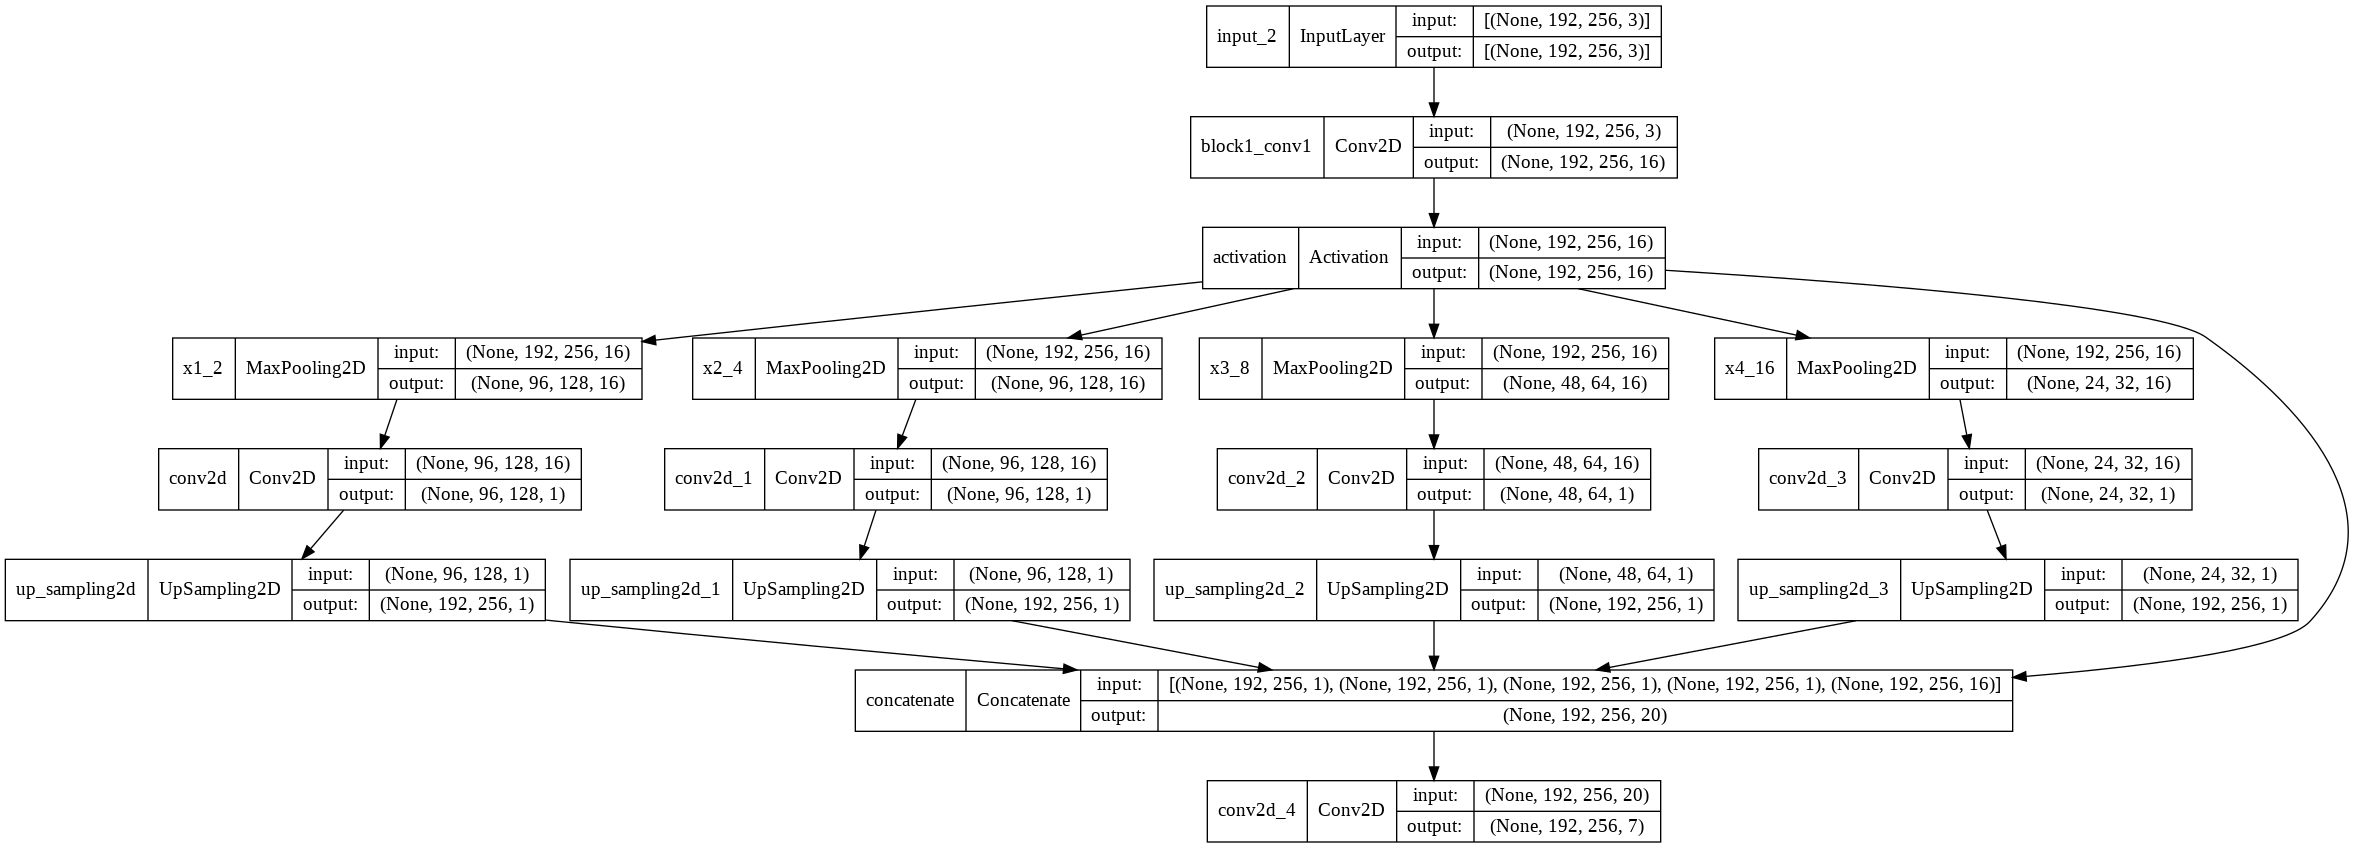

In [27]:
# в общем и целом у нас получилась вот такая модель

inp = Input(shape=(192, 256, 3))
x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(inp)
#x = Conv2D(32, (3, 3), padding='same')(inp)
#x = MaxPooling2D()(inp)
block_1_out = Activation('relu')(x)                                    
x1 = MaxPooling2D(name='x1_2')(block_1_out)                                      
x2 = MaxPooling2D(pool_size=(2, 2), name='x2_4')(block_1_out)                                      
x3 = MaxPooling2D(pool_size=(4, 4), name='x3_8')(block_1_out)                                       
x4 = MaxPooling2D(pool_size=(8, 8), name='x4_16')(block_1_out)

x1= Conv2D(1, (1, 1))(x1)
x2= Conv2D(1, (1, 1))(x2)
x3= Conv2D(1, (1, 1))(x3)                                    
x4= Conv2D(1, (1, 1))(x4)

x1= UpSampling2D()(x1)
x2= UpSampling2D(size=(2, 2))(x2)
x3= UpSampling2D(size=(4, 4))(x3)
x4= UpSampling2D(size=(8, 8))(x4)

block_1_out= concatenate([x1, x2, x3, x4, block_1_out]) 
block_1_out=Conv2D(7, (1, 1))(block_1_out)

print(block_1_out)
model = Model(inp, block_1_out)
plot_model(model, show_shapes=True)

In [29]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 7):
    indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
    fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(xVal[idx].reshape(1, IMG_WIDTH, IMG_HEIGHT, 3))) # Предиктим картику
        pr = predict[0] # Берем нулевой элемент из перидкта
        pr1 = [] # Пустой лист под сегментированную картинку из predicta
        pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель
        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(IMG_WIDTH, IMG_HEIGHT,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(IMG_WIDTH, IMG_HEIGHT,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
        axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    plt.show()  

In [33]:
'''
  Функция создания сети PSPnet
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPnet4(num_classes = 7, inp = Input(shape=(192, 256, 3))):

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(inp) 
    x = BatchNormalization()(x)                                            

    block_1_out = Activation('relu')(x) 

    x1 = MaxPooling2D()(block_1_out)                                      
    x2 = MaxPooling2D(pool_size=(2, 2), name='x2_2')(block_1_out)                                      
    x3 = MaxPooling2D(pool_size=(4, 4), name='x3_3')(block_1_out)                                       
    x4 = MaxPooling2D(pool_size=(8, 8), name='x4_8')(block_1_out)

    x1= Conv2D(1, (1, 1))(x1)
    x2= Conv2D(1, (1, 1))(x2)
    x3= Conv2D(1, (1, 1))(x3)                                    
    x4= Conv2D(1, (1, 1))(x4)

    x1= UpSampling2D()(x1)
    x2= UpSampling2D(size=(2, 2))(x2)
    x3= UpSampling2D(size=(4, 4))(x3)
    x4= UpSampling2D(size=(8, 8))(x4)

    block_1_out= concatenate([x1, x2, x3, x4, block_1_out]) 
    block_1_out=Conv2D(7, (1, 1))(block_1_out)

    #print(block_1_out)
    model = Model(inp, block_1_out)
    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [34]:
model4 = PSPnet4(num_classes, inp = Input(shape=(192, 256, 3))) # Создаем модель 
history = model4.fit(xTrain, yTrain, epochs=4, batch_size=16, validation_data=(xVal, yVal)) # Обучаем модель

Epoch 1/4
119/119 [==============================] - 189s 2s/step - loss: 5.5554 - dice_coef: 0.5292 - val_loss: 5.7752 - val_dice_coef: -29.1497
Epoch 2/4
119/119 [==============================] - 189s 2s/step - loss: 3.8692 - dice_coef: 0.5337 - val_loss: 3.7732 - val_dice_coef: 0.4066
Epoch 3/4
119/119 [==============================] - 190s 2s/step - loss: 3.1059 - dice_coef: 0.5029 - val_loss: 3.0605 - val_dice_coef: 0.4888
Epoch 4/4
119/119 [==============================] - 200s 2s/step - loss: 2.5472 - dice_coef: 0.5176 - val_loss: 3.0258 - val_dice_coef: 0.5201


Лосс падает, коэффициент Дайса растет, дообучим-ка мы модель еще на 5 эпохах

In [35]:
model4 = PSPnet4(num_classes, inp = Input(shape=(192, 256, 3))) # Создаем модель 
history = model4.fit(xTrain, yTrain, epochs=5, batch_size=16, validation_data=(xVal, yVal)) # Обучаем модель

Epoch 1/5
119/119 [==============================] - 189s 2s/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan
Epoch 2/5
119/119 [==============================] - 177s 1s/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan
Epoch 3/5
119/119 [==============================] - 176s 1s/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan
Epoch 4/5
119/119 [==============================] - 199s 2s/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan
Epoch 5/5
119/119 [==============================] - 237s 2s/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan


В итоге,  модель переобучилась и ничего не выучила...
попробуем создать более продуманную модель, добавим слои BatchNormalization и Activation('relu'). Посмотрим, обучится ли модель, и какого уровня метрики удастся достичь:

In [36]:
'''
  Функция создания сети PSPnet
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPnet5(num_classes = 7, inp = Input(shape=(192, 256, 3))):

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(inp) 
    x = BatchNormalization()(x)                                            

    block_1_out = Activation('relu')(x) 

    x1 = MaxPooling2D()(block_1_out)                                      
    x2 = MaxPooling2D(pool_size=(2, 2), name='x2_2')(block_1_out)                                      
    x3 = MaxPooling2D(pool_size=(4, 4), name='x3_3')(block_1_out)                                       
    x4 = MaxPooling2D(pool_size=(8, 8), name='x4_8')(block_1_out)

    x1= Conv2D(1, (1, 1))(x1)
    x1 = BatchNormalization()(x1) 
    x1 = Activation('relu')(x1) 

    x2= Conv2D(1, (1, 1))(x2)
    x2 = BatchNormalization()(x2) 
    x2 = Activation('relu')(x2) 

    x3= Conv2D(1, (1, 1))(x3)   
    x3 = BatchNormalization()(x3) 
    x3 = Activation('relu')(x3) 

    x4= Conv2D(1, (1, 1))(x4)
    x4 = BatchNormalization()(x4) 
    x4 = Activation('relu')(x4) 

    x1= UpSampling2D()(x1)
    x2= UpSampling2D(size=(2, 2))(x2)
    x3= UpSampling2D(size=(4, 4))(x3)
    x4= UpSampling2D(size=(8, 8))(x4)

    block_1_out= concatenate([x1, x2, x3, x4, block_1_out]) 
    block_1_out = Conv2D(16, (3, 3), padding='same')(block_1_out)                             
    block_1_out = BatchNormalization()(block_1_out)                                            
    block_1_out = Activation('relu')(block_1_out)  

    block_1_out=Conv2D(7, (1, 1), activation='softmax')(block_1_out)
    #print(block_1_out)
    model = Model(inp, block_1_out)
    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [37]:
model5 = PSPnet5(num_classes, inp = Input(shape=(192, 256, 3))) # Создаем модель 
history = model5.fit(xTrain, yTrain, epochs=5, batch_size=16, validation_data=(xVal, yVal)) # Обучаем модель

Epoch 1/5
119/119 [==============================] - 291s 2s/step - loss: 1.9210 - dice_coef: 0.1664 - val_loss: 2.1309 - val_dice_coef: 0.1416
Epoch 2/5
119/119 [==============================] - 291s 2s/step - loss: 1.7428 - dice_coef: 0.1954 - val_loss: 1.8525 - val_dice_coef: 0.1783
Epoch 3/5
119/119 [==============================] - 307s 3s/step - loss: 1.6447 - dice_coef: 0.2184 - val_loss: 1.7029 - val_dice_coef: 0.2071
Epoch 4/5
119/119 [==============================] - 287s 2s/step - loss: 1.5782 - dice_coef: 0.2372 - val_loss: 1.6507 - val_dice_coef: 0.2265
Epoch 5/5
119/119 [==============================] - 282s 2s/step - loss: 1.5254 - dice_coef: 0.2532 - val_loss: 1.6140 - val_dice_coef: 0.2362


Уже шаг вперед - модель что-то выучила, метрика пока невысока, так что попробуем добавить еще слоев после каждого апсемплинга

In [26]:
'''
  Функция создания сети PSPnet
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPnet7(num_classes = 7, inp = Input(shape=(192, 256, 3))):

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(inp) 
    x = BatchNormalization()(x)  
    x = Activation('relu')(x)        

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(inp) 
    x = BatchNormalization()(x)                                       
    block_1_out = Activation('relu')(x) 

    x1 = MaxPooling2D()(block_1_out)                                      
    x2 = MaxPooling2D(pool_size=(2, 2), name='x2_2')(block_1_out)                                      
    x3 = MaxPooling2D(pool_size=(4, 4), name='x3_3')(block_1_out)                                       
    x4 = MaxPooling2D(pool_size=(8, 8), name='x4_8')(block_1_out)

    x1= Conv2D(1, (1, 1))(x1)
    x1 = BatchNormalization()(x1) 
    x1 = Activation('relu')(x1) 

    x2= Conv2D(1, (1, 1))(x2)
    x2 = BatchNormalization()(x2) 
    x2 = Activation('relu')(x2) 

    x3= Conv2D(1, (1, 1))(x3)   
    x3 = BatchNormalization()(x3) 
    x3 = Activation('relu')(x3) 

    x4= Conv2D(1, (1, 1))(x4)
    x4 = BatchNormalization()(x4) 
    x4 = Activation('relu')(x4) 

    x1= UpSampling2D()(x1)
    x1 = BatchNormalization()(x1) 
    x1 = Activation('relu')(x1) 

    x2= UpSampling2D(size=(2, 2))(x2)
    x2 = BatchNormalization()(x2) 
    x2 = Activation('relu')(x2) 

    x3= UpSampling2D(size=(4, 4))(x3)
    x3 = BatchNormalization()(x3) 
    x3 = Activation('relu')(x3) 

    x4= UpSampling2D(size=(8, 8))(x4)
    x4 = BatchNormalization()(x4) 
    x4 = Activation('relu')(x4) 

    block_1_out= concatenate([x1, x2, x3, x4, block_1_out]) 
    block_1_out = Conv2D(16, (3, 3), padding='same')(block_1_out)                             
    block_1_out = BatchNormalization()(block_1_out)                                            
    block_1_out = Activation('relu')(block_1_out)  

    block_1_out = Conv2D(16, (3, 3), padding='same')(block_1_out)                             
    block_1_out = BatchNormalization()(block_1_out)                                            
    block_1_out = Activation('relu')(block_1_out)  

    block_1_out=Conv2D(7, (1, 1), activation='softmax')(block_1_out)
    #print(block_1_out)
    model = Model(inp, block_1_out)
    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [27]:
model7 = PSPnet7(num_classes, inp = Input(shape=(192, 256, 3))) # Создаем модель 
history = model7.fit(xTrain, yTrain, epochs=20, batch_size=16, validation_data=(xVal, yVal)) # Обучаем модель

Epoch 1/20
119/119 [==============================] - 399s 3s/step - loss: 1.9110 - dice_coef: 0.1816 - val_loss: 1.8963 - val_dice_coef: 0.1569
Epoch 2/20
119/119 [==============================] - 398s 3s/step - loss: 1.7448 - dice_coef: 0.2100 - val_loss: 1.8078 - val_dice_coef: 0.1870
Epoch 3/20
119/119 [==============================] - 392s 3s/step - loss: 1.6572 - dice_coef: 0.2326 - val_loss: 1.6985 - val_dice_coef: 0.2284
Epoch 4/20
119/119 [==============================] - 397s 3s/step - loss: 1.5949 - dice_coef: 0.2515 - val_loss: 1.6625 - val_dice_coef: 0.2367
Epoch 5/20
119/119 [==============================] - 394s 3s/step - loss: 1.5465 - dice_coef: 0.2675 - val_loss: 1.6419 - val_dice_coef: 0.2441
Epoch 6/20
119/119 [==============================] - 399s 3s/step - loss: 1.5039 - dice_coef: 0.2842 - val_loss: 1.6143 - val_dice_coef: 0.2550
Epoch 7/20
119/119 [==============================] - 395s 3s/step - loss: 1.4679 - dice_coef: 0.2987 - val_loss: 1.6174 - val_dic

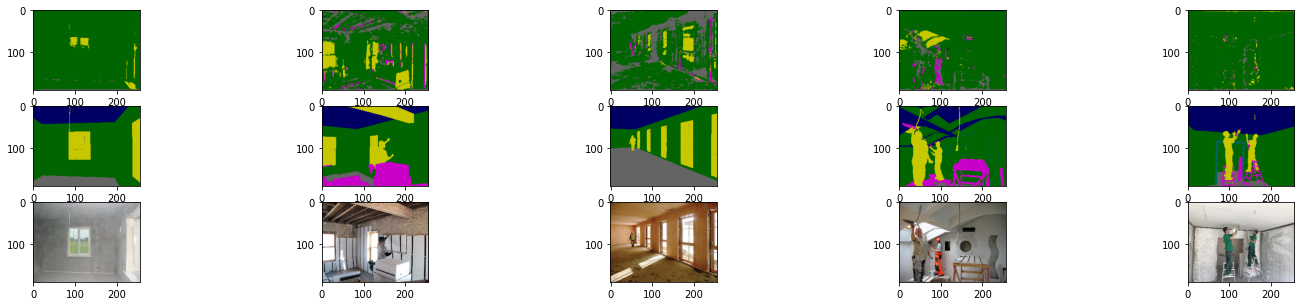

In [30]:
processImage(model7, 5, num_classes)

Удалось еще улучшить нашу модель, к тому же, тренд метрики растущий, можно было бы добавить еще эпох, модель бы, вероятно, выучилась лучше. Теперь при визуализации результатов даже можно увидеть, что модель-таки что-то распознает, но пока далеко от идеала. Попробуем добавить нейронов в первые и последние слои нашей сети. Поможет ли это?

In [37]:
'''
  Функция создания сети PSPnet
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPnet8(num_classes = 7, inp = Input(shape=(192, 256, 3))):

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(inp) 
    x = BatchNormalization()(x)  
    x = Activation('relu')(x)        

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(inp) 
    x = BatchNormalization()(x)                                       
    block_1_out = Activation('relu')(x) 

    x1 = MaxPooling2D()(block_1_out)                                      
    x2 = MaxPooling2D(pool_size=(2, 2), name='x2_2')(block_1_out)                                      
    x3 = MaxPooling2D(pool_size=(4, 4), name='x3_3')(block_1_out)                                       
    x4 = MaxPooling2D(pool_size=(8, 8), name='x4_8')(block_1_out)

    x1= Conv2D(1, (1, 1))(x1)
    x1 = BatchNormalization()(x1) 
    x1 = Activation('relu')(x1) 

    x2= Conv2D(1, (1, 1))(x2)
    x2 = BatchNormalization()(x2) 
    x2 = Activation('relu')(x2) 

    x3= Conv2D(1, (1, 1))(x3)   
    x3 = BatchNormalization()(x3) 
    x3 = Activation('relu')(x3) 

    x4= Conv2D(1, (1, 1))(x4)
    x4 = BatchNormalization()(x4) 
    x4 = Activation('relu')(x4) 

    x1= UpSampling2D()(x1)
    x1 = BatchNormalization()(x1) 
    x1 = Activation('relu')(x1) 

    x2= UpSampling2D(size=(2, 2))(x2)
    x2 = BatchNormalization()(x2) 
    x2 = Activation('relu')(x2) 

    x3= UpSampling2D(size=(4, 4))(x3)
    x3 = BatchNormalization()(x3) 
    x3 = Activation('relu')(x3) 

    x4= UpSampling2D(size=(8, 8))(x4)
    x4 = BatchNormalization()(x4) 
    x4 = Activation('relu')(x4) 

    block_1_out= concatenate([x1, x2, x3, x4, block_1_out]) 
    block_1_out = Conv2D(16, (3, 3), padding='same')(block_1_out)                             
    block_1_out = BatchNormalization()(block_1_out)                                            
    block_1_out = Activation('relu')(block_1_out)  

    block_1_out = Conv2D(32, (3, 3), padding='same')(block_1_out)                             
    block_1_out = BatchNormalization()(block_1_out)                                            
    block_1_out = Activation('relu')(block_1_out)  

    block_1_out=Conv2D(7, (1, 1), activation='softmax')(block_1_out)
    #print(block_1_out)
    model = Model(inp, block_1_out)
    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [38]:
model8 = PSPnet8(num_classes, inp = Input(shape=(192, 256, 3))) # Создаем модель 
history = model8.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xVal, yVal)) # Обучаем модель

Epoch 1/10
60/60 [==============================] - 597s 10s/step - loss: 1.8524 - dice_coef: 0.1954 - val_loss: 2.9712 - val_dice_coef: 0.1211
Epoch 2/10
60/60 [==============================] - 585s 10s/step - loss: 1.6658 - dice_coef: 0.2242 - val_loss: 2.5186 - val_dice_coef: 0.1380
Epoch 3/10
60/60 [==============================] - 619s 10s/step - loss: 1.5635 - dice_coef: 0.2469 - val_loss: 2.0166 - val_dice_coef: 0.1759
Epoch 4/10
60/60 [==============================] - 600s 10s/step - loss: 1.4992 - dice_coef: 0.2658 - val_loss: 1.7167 - val_dice_coef: 0.2189
Epoch 5/10
60/60 [==============================] - 585s 10s/step - loss: 1.4545 - dice_coef: 0.2805 - val_loss: 1.6292 - val_dice_coef: 0.2438
Epoch 6/10
60/60 [==============================] - 583s 10s/step - loss: 1.4186 - dice_coef: 0.2953 - val_loss: 1.5895 - val_dice_coef: 0.2592
Epoch 7/10
60/60 [==============================] - 577s 10s/step - loss: 1.3897 - dice_coef: 0.3080 - val_loss: 1.5589 - val_dice_coef:

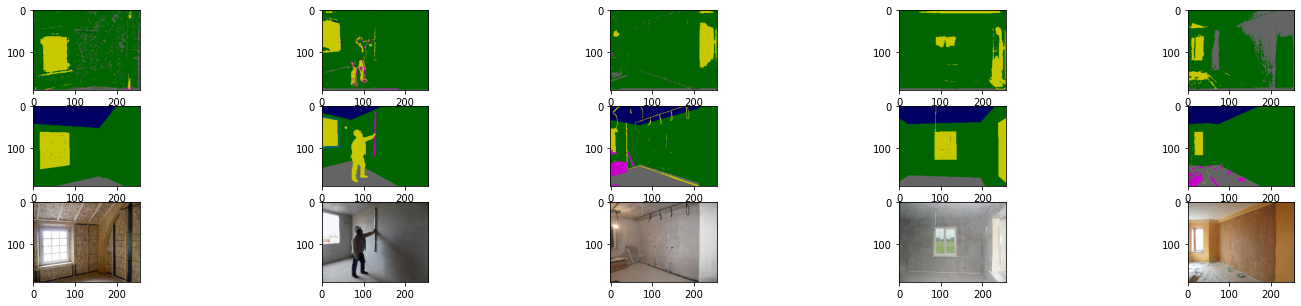

In [39]:
processImage(model8, 5, num_classes)

Честно признаться, результаты - так себе. Из положительного - удалось добиться примерно сопоставимых результатов, что и в предыдущей модели, за в два раза меньшее количество эпох. Вероятно, поработав еще над структурой модели, поэкспериментировав с количеством нейронов и функциями активации, можно было бы достичь лучших результатов. Проблем в дальнейшем исследовании на мой взгляд 2 - первая - модель долго считается, 2 часа на каждую попытку - это много, конечно.